In [10]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [11]:
learning_rate = 0.0002
size_of_batch = 64
num_epochs = 10
critic_iter = 5
noise_dim = 100
output_folder="./WGANOutput"

In [12]:
data_set = datasets.CIFAR10(root="./data", download=True, transform=transforms.Compose([
    transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
        )
    def forward(self, passedInput):
        return self.main(passedInput).mean(0).view(1)


class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, passedInput):
        return self.main(passedInput)

In [15]:
discriminator = Discriminator()

generator = Generator()

discriminator.apply(weights_init)
generator.apply(weights_init)
discriminator
generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [16]:

dis_optim = optim.RMSprop(discriminator.parameters(),lr=learning_rate)
gen_optim = optim.RMSprop(generator.parameters(),lr=learning_rate)
criterion = nn.BCELoss()

real_value = 1
fake_value = 0
input_tensor = torch.FloatTensor(size_of_batch, 3, 64, 64)
noise = torch.FloatTensor(size_of_batch, noise_dim, 1, 1)
norm_noise = torch.FloatTensor(size_of_batch, noise_dim, 1, 1).normal_(0, 1)
norm_noise = Variable(norm_noise)
ones_tensor = torch.FloatTensor([1])
nOnesTensor=ones_tensor * (-1)
criterion.cuda()


disc_loss_list = []
gen_loss_list = []
count_list = []
count = 0 

In [19]:
for epoch in range(num_epochs):
    epochData = iter(data_loader)
    data_counter = 0
    
    
    while data_counter < len(data_loader):
        for param in discriminator.parameters():
            param.requires_grad=True
        
        
        critic_counter = 0
        while data_counter < len(data_loader) and critic_counter < critic_iter:
            data = next(epochData)
            critic_counter += 1
            for param in discriminator.parameters():
                param.data.clamp_(-1e-2, 1e-2)
            data_counter += 1
            
            
            dis_optim.zero_grad()
            real_data, _ = data
            size_of_batch = real_data.size(0)
            real_data = real_data
            input_tensor.resize_as_(real_data).copy_(real_data)
            input_var = Variable(input_tensor)
            dis_real_error = discriminator(input_var)
            dis_real_error.backward(ones_tensor)

            
            noise.resize_(size_of_batch, noise_dim, 1,1).normal_(0,1)
            noise_var = Variable(noise)
            fake_data = generator(noise_var)
            dis_fake_error = discriminator(fake_data.detach())
            dis_fake_error.backward(nOnesTensor)
            dis_optim.step()
            final_dis_error = -dis_fake_error + dis_real_error
            
        
        for param in discriminator.parameters():
            param.requires_grad = False
        gen_optim.zero_grad()
        gen_error = discriminator(fake_data)
        gen_error.backward(ones_tensor)
        gen_optim.step()
        
        
        print('[%d/%d][%d/%d] DLoss: %.4f GLoss: %.4f' % 
             (epoch, num_epochs, data_counter, len(data_loader), final_dis_error.data[0], gen_error.data[0]))

        count += 1
        count_list.append(count)
        gen_loss_list.append(gen_error.data.cpu().numpy()[0])
        disc_loss_list.append(final_dis_error.data.cpu().numpy()[0])
    
    
    fake_data = generator(norm_noise)
    fake_data.data = fake_data.data.mul(0.5).add(0.5)
    vutils.save_image(fake_data.data, '%s/fake_samples_epoch_%03d.png' % 
                      (output_folder, epoch), normalize=True)

[0/10][5/391] DLoss: -1.1559 GLoss: 0.6322
[0/10][10/391] DLoss: -1.2555 GLoss: 0.6695
[0/10][15/391] DLoss: -1.2417 GLoss: 0.6286
[0/10][20/391] DLoss: -1.0554 GLoss: 0.6666
[0/10][25/391] DLoss: -1.2417 GLoss: 0.6412
[0/10][30/391] DLoss: -0.9219 GLoss: 0.6736
[0/10][35/391] DLoss: -1.0999 GLoss: 0.5919
[0/10][40/391] DLoss: -0.8207 GLoss: 0.6790
[0/10][45/391] DLoss: -1.1751 GLoss: 0.6033
[0/10][50/391] DLoss: -1.0898 GLoss: 0.6599
[0/10][55/391] DLoss: -1.1180 GLoss: 0.5907
[0/10][60/391] DLoss: -0.5503 GLoss: 0.6527
[0/10][65/391] DLoss: -1.1902 GLoss: 0.6030
[0/10][70/391] DLoss: -1.0549 GLoss: 0.6287
[0/10][75/391] DLoss: -1.1292 GLoss: 0.6339
[0/10][80/391] DLoss: -0.9152 GLoss: 0.6367
[0/10][85/391] DLoss: -0.9988 GLoss: 0.5194
[0/10][90/391] DLoss: -1.1299 GLoss: 0.5816
[0/10][95/391] DLoss: -1.0323 GLoss: 0.6680
[0/10][100/391] DLoss: -1.1594 GLoss: 0.6054
[0/10][105/391] DLoss: -1.1298 GLoss: 0.6497
[0/10][110/391] DLoss: -1.1338 GLoss: 0.6269
[0/10][115/391] DLoss: -0.7624

[2/10][135/391] DLoss: -1.1337 GLoss: 0.6061
[2/10][140/391] DLoss: -0.6768 GLoss: 0.6532
[2/10][145/391] DLoss: -0.8441 GLoss: 0.2049
[2/10][150/391] DLoss: -0.9803 GLoss: 0.6476
[2/10][155/391] DLoss: -1.1643 GLoss: 0.6184
[2/10][160/391] DLoss: -1.1853 GLoss: 0.6270
[2/10][165/391] DLoss: -1.1537 GLoss: 0.6378
[2/10][170/391] DLoss: -1.1358 GLoss: 0.5826
[2/10][175/391] DLoss: -0.3179 GLoss: 0.5546
[2/10][180/391] DLoss: -1.0698 GLoss: 0.6137
[2/10][185/391] DLoss: -0.9912 GLoss: 0.3256
[2/10][190/391] DLoss: -1.0552 GLoss: 0.5675
[2/10][195/391] DLoss: -0.8558 GLoss: 0.6327
[2/10][200/391] DLoss: -1.1183 GLoss: 0.5752
[2/10][205/391] DLoss: -0.6424 GLoss: 0.6400
[2/10][210/391] DLoss: -0.9903 GLoss: 0.4809
[2/10][215/391] DLoss: -1.0143 GLoss: 0.6045
[2/10][220/391] DLoss: -1.0316 GLoss: 0.5983
[2/10][225/391] DLoss: -1.0839 GLoss: 0.6330
[2/10][230/391] DLoss: -1.0028 GLoss: 0.4132
[2/10][235/391] DLoss: -0.8405 GLoss: 0.6399
[2/10][240/391] DLoss: -1.0588 GLoss: 0.5627
[2/10][245

[4/10][260/391] DLoss: -0.5958 GLoss: 0.5948
[4/10][265/391] DLoss: -0.7666 GLoss: 0.1761
[4/10][270/391] DLoss: -0.9170 GLoss: 0.4920
[4/10][275/391] DLoss: -0.9692 GLoss: 0.6173
[4/10][280/391] DLoss: -1.0314 GLoss: 0.5692
[4/10][285/391] DLoss: -0.9669 GLoss: 0.5214
[4/10][290/391] DLoss: -0.7350 GLoss: 0.5998
[4/10][295/391] DLoss: -0.7771 GLoss: 0.1822
[4/10][300/391] DLoss: -0.7417 GLoss: 0.2511
[4/10][305/391] DLoss: -0.9344 GLoss: 0.4129
[4/10][310/391] DLoss: -0.9494 GLoss: 0.5924
[4/10][315/391] DLoss: -1.0417 GLoss: 0.5118
[4/10][320/391] DLoss: -0.6467 GLoss: 0.6279
[4/10][325/391] DLoss: -0.7073 GLoss: 0.0072
[4/10][330/391] DLoss: -0.8350 GLoss: 0.4429
[4/10][335/391] DLoss: -0.9539 GLoss: 0.6051
[4/10][340/391] DLoss: -1.0283 GLoss: 0.4942
[4/10][345/391] DLoss: -0.7099 GLoss: 0.6181
[4/10][350/391] DLoss: -0.8100 GLoss: 0.3394
[4/10][355/391] DLoss: -0.7732 GLoss: 0.6312
[4/10][360/391] DLoss: -0.9548 GLoss: 0.4894
[4/10][365/391] DLoss: -0.8653 GLoss: 0.6050
[4/10][370

[6/10][385/391] DLoss: -1.1090 GLoss: 0.6412
[6/10][390/391] DLoss: -1.1559 GLoss: 0.6132
[6/10][391/391] DLoss: -1.0501 GLoss: 0.5440
[7/10][5/391] DLoss: -0.9866 GLoss: 0.4028
[7/10][10/391] DLoss: -0.7737 GLoss: 0.6488
[7/10][15/391] DLoss: -0.5370 GLoss: 0.0382
[7/10][20/391] DLoss: -1.0085 GLoss: 0.3570
[7/10][25/391] DLoss: -1.0225 GLoss: 0.5888
[7/10][30/391] DLoss: -0.7551 GLoss: 0.0216
[7/10][35/391] DLoss: -0.9972 GLoss: 0.6533
[7/10][40/391] DLoss: -1.2286 GLoss: 0.6201
[7/10][45/391] DLoss: -0.8628 GLoss: 0.6415
[7/10][50/391] DLoss: -1.0712 GLoss: 0.4955
[7/10][55/391] DLoss: -0.7895 GLoss: 0.6568
[7/10][60/391] DLoss: -0.5450 GLoss: 0.1632
[7/10][65/391] DLoss: -1.1865 GLoss: 0.5959
[7/10][70/391] DLoss: -1.0657 GLoss: 0.4755
[7/10][75/391] DLoss: -1.0416 GLoss: 0.4840
[7/10][80/391] DLoss: -0.8318 GLoss: 0.6418
[7/10][85/391] DLoss: -0.7235 GLoss: 0.1786
[7/10][90/391] DLoss: -1.2501 GLoss: 0.6333
[7/10][95/391] DLoss: -1.2452 GLoss: 0.6220
[7/10][100/391] DLoss: -1.2516

[9/10][120/391] DLoss: -0.4927 GLoss: -0.0659
[9/10][125/391] DLoss: -1.2425 GLoss: 0.6266
[9/10][130/391] DLoss: -1.2576 GLoss: 0.6407
[9/10][135/391] DLoss: -1.2261 GLoss: 0.6280
[9/10][140/391] DLoss: -1.1869 GLoss: 0.6105
[9/10][145/391] DLoss: -0.8357 GLoss: 0.6748
[9/10][150/391] DLoss: -0.8131 GLoss: 0.6714
[9/10][155/391] DLoss: -0.1862 GLoss: 0.5482
[9/10][160/391] DLoss: -0.6644 GLoss: -0.2556
[9/10][165/391] DLoss: -0.9000 GLoss: 0.0307
[9/10][170/391] DLoss: -0.9539 GLoss: 0.6578
[9/10][175/391] DLoss: -1.2490 GLoss: 0.6328
[9/10][180/391] DLoss: -1.2176 GLoss: 0.6322
[9/10][185/391] DLoss: -1.1443 GLoss: 0.5676
[9/10][190/391] DLoss: -0.7137 GLoss: 0.6848
[9/10][195/391] DLoss: -0.7821 GLoss: 0.6900
[9/10][200/391] DLoss: -0.8309 GLoss: 0.6763
[9/10][205/391] DLoss: -0.9983 GLoss: 0.4495
[9/10][210/391] DLoss: -1.0981 GLoss: 0.6625
[9/10][215/391] DLoss: -0.7825 GLoss: -0.2270
[9/10][220/391] DLoss: -1.3026 GLoss: 0.6640
[9/10][225/391] DLoss: -1.3201 GLoss: 0.6630
[9/10][

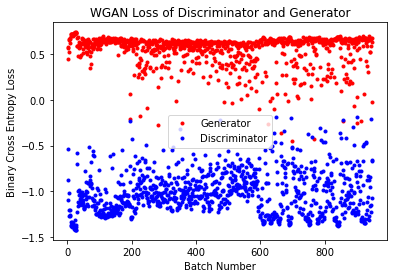

In [20]:
plt.plot(count_list, gen_loss_list, 'r.', label='Generator')
plt.plot(count_list, disc_loss_list, 'b.', label='Discriminator')
plt.title("WGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend(loc = "best")
plt.show()